## Import Libraries

In [67]:
# 環境によって処理を変えるためのもの
import sys
import os
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = 'kaggle_web_client' in sys.modules
LOCAL = not (IN_KAGGLE or IN_COLAB)
print(f'IN_COLAB:{IN_COLAB}, IN_KAGGLE:{IN_KAGGLE}, LOCAL:{LOCAL}')

IN_COLAB:False, IN_KAGGLE:False, LOCAL:True


In [ ]:
if IN_KAGGLE or IN_COLAB:
    !pip install --upgrade -q wandb
    !pip install setuptools==57.4.0 -q
    !pip install xfeat -q

In [68]:
# Hide Warning
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Python Libraries
import os
import math
import random
import glob
import pickle
import gc
from pathlib import Path

# Third party
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import GroupKFold,StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error,roc_auc_score,accuracy_score

import category_encoders as ce
from xfeat import *
import optuna

# GBDT models
import xgboost as xgb
import lightgbm as lgb
import catboost
from catboost import CatBoost
from catboost import Pool

print(f'xgb:{xgb.__version__}')
print(f'lgb:{lgb.__version__}')
print(f'lgb:{catboost.__version__}')
print(f'optuna:{optuna.__version__}')

def set_seed(seed: int=29):
    print(f'set_seed{seed}')
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
set_seed()

xgb:1.5.1
lgb:2.3.0
lgb:1.0.5
optuna:2.3.0
set_seed29


In [69]:
class CFG:
    competition = 'spaceship_titanic'
    exp_name = 'template'
    seed = [2,29]
    target_col = 'Transported'
    n_fold = 5
    trn_fold = [0,1,2,3,4]
    
    # COL
    cate_cols = []
    cont_cols = []
    feature_cols = []

In [70]:
def simpleEDA1(df):
    print(f'dataframe shape is {df.shape}')
    display(pd.concat([
        pd.DataFrame(df.dtypes.rename("dtypes")).T,
        pd.DataFrame(df.isnull().sum().rename("isnull")).T,
        pd.DataFrame(df.nunique().rename("nunique")).T,
        df.describe(include='all')
    ]).T)
    
def metric(true, pred):
    """コンペの評価指標 CVに使う"""
#     print('RMSPE')
    # score = np.sqrt(mean_squared_error(true, pred))
    score = mean_absolute_error(true, pred)
    return score

def save_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)
        
def load_pickle(filename):
    with open(filename, mode='rb') as f:
        p = pickle.load(f)
    return p 

In [71]:
if IN_KAGGLE:
    INPUT_DIR = Path('../input/spaceship-titanic')
    OUTPUT_DIR = './'
    FEAT_DIR = Path('../input/sony-fe')
elif IN_COLAB:
    INPUT_DIR = Path('/content/input/')
    OUTPUT_DIR = f'/content/drive/MyDrive/kaggle/spaceship-titanic/{CFG.exp_name}/'
if LOCAL:
    INPUT_DIR = Path("F:/Kaggle/spaceship-titanic/data/input/")
    OUTPUT_DIR = f'F:/Kaggle/spaceship-titanic/data/output/{CFG.exp_name}/'
    FEAT_DIR = Path("F:/Kaggle/spaceship-titanic/data/input/features")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
df_train = pd.read_csv(INPUT_DIR / "train.csv")
df_test = pd.read_csv(INPUT_DIR / "test.csv")
df_sub = pd.read_csv(INPUT_DIR / "sample_submission.csv")
df_oof = df_train.copy()
display(df_train.head())
display(df_test.head())
display(df_sub.head())

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [72]:
simpleEDA1(df_train)

dataframe shape is (8693, 14)


,dtypes,isnull,nunique,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,object,0,8693,8693,8693,0001_01,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HomePlanet,object,201,3,8492,3,Earth,4602,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CryoSleep,object,217,2,8476,2,False,5439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Cabin,object,199,6560,8494,6560,G/734/S,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Destination,object,182,3,8511,3,TRAPPIST-1e,5915,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,float64,179,80,8514.0,NaN,NaN,NaN,28.82793,14.489021,0.0,19.0,27.0,38.0,79.0
VIP,object,203,2,8490,2,False,8291,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RoomService,float64,181,1273,8512.0,NaN,NaN,NaN,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,float64,183,1507,8510.0,NaN,NaN,NaN,458.077203,1611.48924,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,float64,208,1115,8485.0,NaN,NaN,NaN,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0


## Feature Engneering

In [73]:
CFG.cate_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', ]
CFG.cont_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
CFG.feature_cols =  CFG.cont_cols  #+ CFG.cate_cols

In [74]:
# Caategory Encodeing
_OE_COLS = ['HomePlanet', 'CryoSleep', 'Destination','VIP']
OE_COLS = ['OE_' + col for col in _OE_COLS]
ce_oe = ce.OrdinalEncoder(cols=_OE_COLS,handle_missing='return_nan')
df_train[OE_COLS] = ce_oe.fit_transform(df_train[_OE_COLS])
df_test[OE_COLS] = ce_oe.transform(df_test[_OE_COLS])
CFG.feature_cols += OE_COLS 

# One-Hot-Encoding
_OHE_COLS = ['HomePlanet', 'CryoSleep', 'Destination','VIP']
ce_ohe = ce.OneHotEncoder(cols=_OHE_COLS, handle_unknown='impute')
_df_ohe = ce_ohe.fit_transform(df_train[_OHE_COLS])
OHE_COLS = _df_ohe.columns.to_list()
df_train[OHE_COLS] = _df_ohe[OHE_COLS]
df_test[OHE_COLS] = ce_ohe.transform(df_test[_OHE_COLS])
# CFG.feature_cols += OHE_COLS 
print(OHE_COLS)

# https://www.kaggle.com/edwintyh/pycaret-spaceship-fe-catboost

['HomePlanet_1', 'HomePlanet_2', 'HomePlanet_3', 'HomePlanet_4', 'CryoSleep_1', 'CryoSleep_2', 'CryoSleep_3', 'Destination_1', 'Destination_2', 'Destination_3', 'Destination_4', 'VIP_1', 'VIP_2', 'VIP_3']


## CV Split

In [75]:
print(df_train.Transported.value_counts())
from sklearn.model_selection import KFold
def get_fold(df, cfg, seed):
    Fold = KFold(n_splits=cfg.n_fold, shuffle=True, random_state=seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[cfg.target_col])):
        df.loc[val_index, 'fold'] = int(n)
    return df
df_train = get_fold(df_train,CFG,CFG.seed[0])
df_oof['fold'] = df_train['fold']
# print(df_train.groupby(['fold', cv_col]).size())
print(df_train.fold.value_counts())

True     4378
False    4315
Name: Transported, dtype: int64
1.0    1739
0.0    1739
2.0    1739
4.0    1738
3.0    1738
Name: fold, dtype: int64


In [76]:
def fit_lgbm(cfg, X_train, y_train, X_valid, y_valid,  params: dict=None, verbose_eval=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid)
    
    model = lgb.train(params,
                      lgb_train,
                      #categorical_feature=['statusCode', 'primaryPositionCode'],
                      valid_sets=[lgb_train, lgb_valid],
#                       categorical_feature = cfg.cate_cols,
                      num_boost_round =10000,
                      verbose_eval=verbose_eval,
                     )
    oof_pred = model.predict(X_valid)
    score = metric(oof_pred, y_valid)
#     print('mae:', score)
#     _ = lgb.plot_importance(model,max_num_features=20,figsize=(10,10))
    return oof_pred, model, score

## Grid Search

In [77]:
# lgb_grid_params = {'objective': ['binary'],
#                    'metric':  ['binary_error'],
#                    'boosting_type': ['gbdt'],
#                    'max_depth' : [7],#[-1,3,5,7],
#                    'num_leaves': [22],
#                    'min_child_samples': [30],
#                    'lambda_l1': [0],
#                    'lambda_l2': [1],
#                    'bagging_freq': [1],
#                    'bagging_fraction': [0.7],
#                    'feature_fraction': [0.4,0.7],
#                    'learning_rate': [0.01],
#                    'seed': [29],
#                    'verbosity': [-1],
#                    'n_jobs': [-1]
# #                     入れると上書きできる
# #                    'num_iterations': [3000],
# #                    'early_stopping_round': [200],
#                   }
# best_param = {}
# best_score = np.inf
# for param in tqdm(ParameterGrid(lgb_grid_params)):
#     # training
#     print('='*50)
#     oof_pred, model, score = fit_lgbm(CFG,
#                                       df_train.loc[df_train['fold'] != 0, CFG.feature_cols],
#                                       df_train.loc[df_train['fold'] != 0, CFG.target_col],
#                                       df_train.loc[df_train['fold'] == 0, CFG.feature_cols],
#                                       df_train.loc[df_train['fold'] == 0, CFG.target_col],
#                                       param,
#                                       verbose_eval=-1)
#     if score < best_score:
#         print(f'Best Score Updated : {score}')
#         best_score = score
#         best_param = param
# print('='*50)
# print(f'best score {best_score}')
# print(best_param)

## Optuna
- https://nykergoto.hatenablog.jp/entry/2019/03/29/%E5%8B%BE%E9%85%8D%E3%83%96%E3%83%BC%E3%82%B9%E3%83%86%E3%82%A3%E3%83%B3%E3%82%B0%E3%81%A7%E5%A4%A7%E4%BA%8B%E3%81%AA%E3%83%91%E3%83%A9%E3%83%A1%E3%83%BC%E3%82%BF%E3%81%AE%E6%B0%97%E6%8C%81%E3%81%A1

In [78]:
# def objective(trial):
#     optuna_params = {'objective': 'binary',
#                      'metric':  'binary_error',
#                      'boosting_type': 'gbdt',
#                      'max_depth': trial.suggest_int('max_depth', low=3, high=8),
#                      'num_leaves': trial.suggest_int("num_leaves", 5, 70),
#                      'min_child_samples' : trial.suggest_int("min_child_samples", 10, 50),
#                      'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-3, 1e3),  # L1 正則化
#                      'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-3, 1e3), # L2 正則化
#                      'bagging_freq': 1,
#                      'bagging_fraction': trial.suggest_loguniform('bagging_fraction', .5, 1.),
#                      'feature_fraction':  trial.suggest_loguniform('feature_fraction', .4, 1.),
#                      'learning_rate': 0.01,
#                      'seed': 29,
#                      'verbosity': -1,
#                      'n_jobs': -1,
#                      # 上書きできる
# #                      'num_iterations': 10000,
# #                      'early_stopping_round': 100,
#                  }


#     oof_pred, model, score = fit_lgbm(CFG,
#                                       df_train.loc[df_train['fold'] != 0, CFG.feature_cols],
#                                       df_train.loc[df_train['fold'] != 0, CFG.target_col],
#                                       df_train.loc[df_train['fold'] == 0, CFG.feature_cols],
#                                       df_train.loc[df_train['fold'] == 0, CFG.target_col],
#                                       optuna_params,
#                                       verbose_eval=-1)
#     return score

# study = optuna.create_study()
# study.optimize(objective, n_trials=1000)
# print('best param')
# print(study.best_params)

## Training

In [79]:
lgb_params = {'objective':'binary',
              'metric':'binary_error',
              'boosting_type': 'gbdt',
              'max_depth' : 7,
              'num_leaves': 22,
              'min_child_samples': 30,
              'lambda_l1': 0.1,
              'lambda_l2': 0.1,
              'bagging_freq': 1,# k回に一回バギング
              'bagging_fraction': 0.7,
              'feature_fraction': 0.40197665929778637,
              'learning_rate': 0.01,
              'early_stopping_round': 100,
              'seed': 29,
              'verbosity': -1,
              'n_jobs': -1,
             }
# bestparamを代入
if 'study' in globals():
    for p in ['max_depth', 'num_leaves','min_child_samples','lambda_l1','lambda_l2','bagging_fraction','feature_fraction']:
        lgb_params[p] = study.best_params[p]
    
def train_lgbm(df_train, df_oof, lgb_params, seed):
    set_seed(seed)
    lgb_params["seed"] = seed
    df_train = get_fold(df_train,CFG, seed)
    df_oof['fold'] = df_train['fold']
    
    models = []
    for fold in range(CFG.n_fold):
        if not fold in CFG.trn_fold:
            continue
        print(f"{'='*38} Fold: {fold} {'='*38}")
        
        # training
        oof_pred, model, score = fit_lgbm(CFG,
                                        df_train.loc[df_train['fold'] != fold, CFG.feature_cols],
                                        df_train.loc[df_train['fold'] != fold, CFG.target_col],
                                        df_train.loc[df_train['fold'] == fold, CFG.feature_cols],
                                        df_train.loc[df_train['fold'] == fold, CFG.target_col],
                                        lgb_params)
        
        # oof
        df_oof.loc[df_train['fold'] == fold,['pred']] = oof_pred
        models.append(model)
    save_pickle(OUTPUT_DIR + f'lgbm_models_{seed}.pkl', models)
    df_oof[[CFG.target_col,'pred']].to_csv(OUTPUT_DIR + f'lgbm_oof_{seed}.csv',index=False)
    print(metric(df_oof.dropna(subset=['pred'])[CFG.target_col],df_oof.dropna(subset=['pred'])['pred']))

In [80]:
# LightGBM
# ============================================
topk=3
for s in CFG.seed:
    train_lgbm(df_train, df_oof, lgb_params, s)

set_seed2
====================================== Fold: 0 ======================================
Training until validation scores don't improve for 100 rounds
[100]	training's binary_error: 0.206787	valid_1's binary_error: 0.207591
[200]	training's binary_error: 0.196002	valid_1's binary_error: 0.205865
Early stopping, best iteration is:
[158]	training's binary_error: 0.198016	valid_1's binary_error: 0.202415
====================================== Fold: 1 ======================================
Training until validation scores don't improve for 100 rounds
[100]	training's binary_error: 0.204055	valid_1's binary_error: 0.214491
[200]	training's binary_error: 0.196146	valid_1's binary_error: 0.20529
Early stopping, best iteration is:
[186]	training's binary_error: 0.19744	valid_1's binary_error: 0.20299
====================================== Fold: 2 ======================================
Training until validation scores don't improve for 100 rounds
[100]	training's binary_error: 0.200748	v

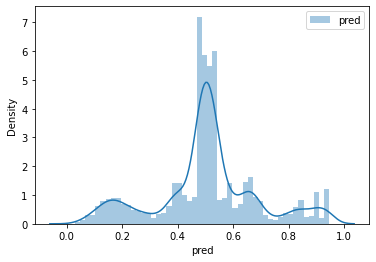

In [81]:
save_pickle(OUTPUT_DIR + 'usefeature.pkl', CFG.feature_cols)
# 予測値のプロット
# sns.distplot(df_oof[CFG.target_col], label=CFG.target_col)
sns.distplot(df_oof['pred'], label='pred')
plt.legend()

## OOF

In [82]:
scores = []
for s in CFG.seed:
    df_oof = pd.read_csv(OUTPUT_DIR + f'lgbm_oof_{s}.csv')
    # cv
    score = metric(df_oof.dropna(subset=['pred'])[CFG.target_col],df_oof.dropna(subset=['pred'])['pred'])
    print(f'seed{s}:{score}')
    scores.append(score)
A=np.array(scores).argsort()#[::-1]
topk_seeds = []
for i in A[:topk]:
    topk_seeds.append(CFG.seed[i])
topk_seeds

seed2:0.38689737285582126
seed29:0.4080798518197932


[2, 29]

In [83]:
print(f'roc_auc:{roc_auc_score(df_oof.Transported, df_oof.pred)}')
df_oof['pred_bool'] = df_oof.pred > 0.5
print(f'accuracy:{accuracy_score(df_oof.Transported, df_oof.pred_bool)}')

roc_auc:0.8285516913546983
accuracy:0.7899459335097204


## inference

100%|██████████| 5/5 [00:00<00:00, 70.41it/s]


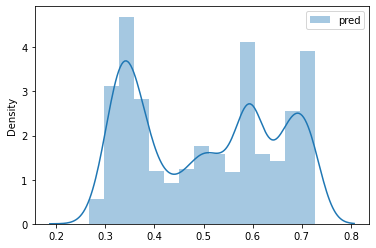

In [84]:
# inference
for s in topk_seeds:
    models = load_pickle(OUTPUT_DIR + f'lgbm_models_{s}.pkl')
    y_preds =[]
    for model in tqdm(models):
        y_pred = model.predict(df_test[CFG.feature_cols], num_iteration=model.best_iteration)
        y_preds.append(y_pred)
    pred = np.mean(y_preds,axis=0)
    # submitファイルを作成
    df_sub['Transported'] = pred > 0.5
    df_sub.to_csv(OUTPUT_DIR + f'submission_{s}.csv',index=False)

sns.distplot(pred, label='pred')
plt.legend()

In [85]:
pd.set_option('display.max_rows', 100)
def view_lgbm_importance(models, features, n_head=0):
    list_imp = []
    for m in models:
        imp = pd.DataFrame(m.feature_importance(importance_type='gain'), columns=['imp'])
        imp['col'] = features
        list_imp.append(imp.set_index('col'))
    imp = sum(list_imp) / len(models)
    if n_head==0:
        display(imp.sort_values('imp', ascending=False))
    else:
        display(imp.sort_values('imp', ascending=False).head(n_head))
    return imp.sort_values('imp', ascending=False)

_ = view_lgbm_importance(models, CFG.feature_cols,100)
_.to_csv(OUTPUT_DIR + 'imp.csv')

,imp
col,
OE_CryoSleep,17868.474099
Spa,10810.009128
VRDeck,9096.961388
RoomService,8564.706984
OE_HomePlanet,7722.291607
FoodCourt,7125.073143
ShoppingMall,5321.053686
Age,3456.169314
OE_Destination,1472.912564
